In [54]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [18]:
main_df[[elem for elem in main_df.columns if elem.startswith('u235')]].melt()

,variable,value
0,u235 in mat15563,0.001892
1,u235 in mat15563,0.001892
2,u235 in mat15563,0.001892
3,u235 in mat15563,0.001892
4,u235 in mat15563,0.001813
...,...,...
3144955,u235 in mat50122,0.001873
3144956,u235 in mat50122,0.001860
3144957,u235 in mat50122,0.001837
3144958,u235 in mat50122,0.001773


In [7]:
main_df.shape

(91, 172801)

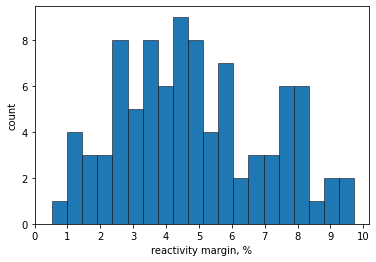

In [4]:
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

In [5]:
main_df.drop(columns=['Keff'], inplace=True)

In [8]:
target = main_df.pop('reactivity_margin')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)

In [26]:
X_train.shape, X_test.shape

((63, 172800), (28, 172800))

In [57]:
lr = LinearRegression(n_jobs=-1)
sgd = SGDRegressor(penalty='l2', 
                   alpha=0.0001, 
                   l1_ratio=0.15, 
                   fit_intercept=True,  
                   tol=0.001, 
                   shuffle=True, 
                   verbose=0, 
                   epsilon=0.1, 
                   random_state=None, 
                   learning_rate='adaptive', 
                   eta0=0.01, 
                   power_t=0.25, 
                   early_stopping=False, 
                   validation_fraction=0.1, 
                   n_iter_no_change=5, 
                   warm_start=True, 
                   average=False)

In [59]:
lr.fit(X_train, y_train)
sgd.fit(X_train, y_train)

SGDRegressor(learning_rate='adaptive', warm_start=True)

In [60]:
y_pred = lr.predict(X_test)

In [61]:
mean_squared_error(y_test, y_pred)

2821454.865789052

In [62]:
y_pred_2 = sgd.predict(X_test)

In [63]:
mean_squared_error(y_test, y_pred_2)

5.281332872773995